In [11]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import legendre
from numpy.polynomial.legendre import legvander
from mpmath import coulombf, coulombg, mp
from scipy.interpolate import interp1d
import csv


In [89]:
def rutherford_diff_cross_section_lab(z1, z2, m1, m2, en_lab, theta_lab):
    """
    Calculates the differential cross section in lab frame for Rutherford scattering in cm^2/Str.
    Formula 2.22 in Chu Backscattering Spectrometry

    Args:
    z1 (int): atomic number of the incident particle
    z2 (int): atomic number of the target particle
    m1 (float): mass of the incident particle (units: arbitrary, but must be consistent with m2)
    m2 (float): mass of the target particle (units: arbitrary, but must be consistent with m1)
    en_lab (float): kinetic energy of the incident particle in MeV in lab frame
    theta_lab (float): scattering angle of the incident particle in degrees in lab frame
    
    Returns:
    float: differential cross section in units of cm^2/sr
    """

    # Define the electric charge squared constant in MeV cm
    electric_charge_sq = 1.4398*10**-13 #MeV cm

    # Convert the scattering angle from degrees to radians
    theta_lab = np.radians(theta_lab)

    # Calculate the first factor in the equation using the input parameters
    first_factor = ((z1*z2*electric_charge_sq)/(4*en_lab))**2

    # Calculate the second factor in the equation using the input parameter
    second_factor = 4/(np.sin(theta_lab)**4)

    # Calculate the third factor's numerator in the equation using the input parameters
    third_factor_numerator = ((1-((m1/m2)*np.sin(theta_lab))**2)**(1/2)+np.cos(theta_lab))**2

    # Calculate the third factor's denominator in the equation using the input parameters
    third_factor_denominator = (1-((m1/m2)*np.sin(theta_lab))**2)**(1/2)

    # Calculate the differential cross section using the first, second, and third factors
    return first_factor*second_factor*third_factor_numerator/third_factor_denominator

def rutherford_diff_cross_section_CM(z1, z2, en_cm, theta_cm):
    """
    Calculates the differential cross section in CM for Rutherford scattering.
    Formula 2.20 in Chu Backscattering Spectrometry

    Args:
    z1 (int): atomic number of the incident particle
    z2 (int): atomic number of the target particle
    en_cm (float): kinetic energy of the incident particle in MeV in CM frame
    theta_cm (float): scattering angle of the incident particle in degrees in CM frame
    
    Returns:
    float: differential cross section in units of cm^2/sr
    """

    # Define the electric charge squared constant in MeV cm
    electric_charge_sq = 1.4398*10**-13 #MeV cm

    # Convert the scattering angle from degrees to radians
    theta_cm = np.radians(theta_cm)

    # Calculate numerator
    numerator = z1*z2*electric_charge_sq

    # Calculate denominator
    denominator = 4*en_cm*np.sin(theta_cm/2)**2

    # Calculate the differential cross section using numerator and denominator
    return (numerator/denominator)**2

def theta_CtoL(theta_C_deg, gamma):
    """
    Convert CM angle(s) theta_C (deg) to lab angle(s) theta_L(deg) using the gamma value.

    Args:
    - theta_C (float or array): The angle(s) in degrees in the original coordinate system.
    - gamma (float): The gamma value used in the conversion.

    Returns:
    - theta_L (float or array): The corresponding angle(s) in degrees in the new coordinate system.
    """
    # Convert to array
    theta_C_deg = np.asarray(theta_C_deg, dtype=float)
    gamma = np.asarray(gamma, dtype=float)
    
    # Convert to radians
    theta_C = np.radians(theta_C_deg)
    
    # Calculate each part of fraction
    num = np.sin(theta_C)
    den = gamma + np.cos(theta_C) 

    # Now take arctan
    theta_L_deg = np.degrees(np.arctan2(num, den)) # [-180, 180]

    # Map to [0, 180] for scattering angles
    theta_L_deg = np.where(theta_L_deg<0, theta_L_deg + 180, theta_L_deg)

    # Check if the angle is 0 or 180 degrees in the original coordinate system or close.
    # If so, set the corresponding angle in the new coordinate system to 0 or 180 degrees.
    # a_tol = 1e-10
    # at_0 =np.isclose((theta_C_deg % 360.0),   0.0, atol=a_tol) | np.isclose((theta_C_deg % 360.0), 360.0, atol=a_tol)
    # at_180 = np.isclose((theta_C_deg % 360.0), 180.0, atol=a_tol)
    
    # theta_L_deg = np.where(at_0, 0.0, theta_L_deg)
    # theta_L_deg = np.where(at_180, 180.0, theta_L_deg)

    return theta_L_deg

def theta_LtoC(theta_L_deg, gamma):
    """
    Convert lab angle(s) theta_L_deg (deg) to CM angle(s) using the gamma value.
    See The Atomic Nucleus pg 420, ch 12

    Args:
    - theta_L_deg (float or array): The angle(s) from 0 to 180 in degrees in the original 
        coordinate system.
    - gamma (float): The gamma value used in the conversion.

    Returns:
    - theta_C (float or array): The corresponding angle(s) in degrees in the new coordinate system.
    """
     
    # Convert to array
    theta_L_deg = np.asarray(theta_L_deg, dtype=float)
    gamma = np.asarray(gamma, dtype=float)

    # Convert to radians
    theta_L = np.radians(theta_L_deg)

    # Solve for angles in cm
    # stop floating point roundoff
    gsin = np.clip(gamma*np.sin(theta_L),-1.0,1.0)
    
    # both branches
    theta_C1 = np.arcsin(gsin)+theta_L
    theta_C2 = (np.pi-np.arcsin(gsin))+theta_L
    # convert to degrees
    theta_C1_deg = np.degrees(theta_C1)
    theta_C2_deg = np.degrees(theta_C2)
    # Test each branch against cm to lab
    lab1 = theta_CtoL(theta_C1_deg,gamma)
    lab2 = theta_CtoL(theta_C2_deg,gamma)
    # Which are in valid range 0 to 180
    valid1 = (theta_C1_deg >= 0) & (theta_C1_deg <= 180)
    valid2 = (theta_C2_deg >= 0) & (theta_C2_deg <= 180)
    # Pick C1 if only C1 is valid
    pick1 = (valid1 == True) & (valid2 == False)
    # If both are valid find least error.
    mask_both = (valid1 == True) & (valid2 == True)
    if np.any(mask_both):
        pick1[mask_both] = (np.abs(lab1[mask_both] - theta_L_deg[mask_both]) \
                             < np.abs(lab2[mask_both] - theta_L_deg[mask_both]))
    # Pick best
    theta_C_best = np.where(pick1,theta_C1_deg, theta_C2_deg)
    # If neither are valid set to NaN.
    mask_none = (valid1 == False) & (valid2 == False)
    if np.any(mask_none):
        theta_C_best = np.NaN

    # return best
    return theta_C_best

def solidAngleRatio_cm2L(theta_C_deg,theta_L_deg,gamma):
    """
    Ratio of solidAngle_cm/solidAngle_lab.
    Can be multiplied by differential cross section in the CM frame to convert to 
    differential cross section in lab.
    See The Atomic Nucleus pg 421, ch 12

    Args:
    - theta_L_deg (float or array): The angle(s) from 0 to 180 in degrees in the original 
        coordinate system.
    - gamma (float): The gamma value used in the conversion.

    Returns:
    - theta_C (float or array): The corresponding angle(s) in degrees in the new coordinate system.
    """
    theta_C_deg = np.asarray(theta_C_deg, dtype=float)
    theta_L_deg = np.asarray(theta_L_deg, dtype=float)
    gamma = np.asarray(gamma, dtype=float)
    
    theta_C = np.radians(theta_C_deg)
    theta_L = np.radians(theta_L_deg)

    first_factor = (np.sin(theta_C)**3)/(np.sin(theta_L)**3)
    second_factor = 1/(1+gamma*np.cos(theta_C))

    return first_factor*second_factor

def en_lab2CM(en_lab,m1,m2):
    """
    Convert incident energy from lab to CM frame.
    See The Atomic Nucleus pg 421, ch 12

    Args:
    - m1 (float): mass of the incident particle (units: arbitrary, but must be consistent with m2)
    - m2 (float): mass of the target particle (units: arbitrary, but must be consistent with m1)
    - en_lab (float): kinetic energy of the incident particle in MeV in lab frame

    Returns:
    - en_cm (float or array): Incident energy in the new coordinate system.
    """
    en_cm = en_lab*m2/(m1+m2)
    return en_cm

def fit_legendre_linear(theta_deg, y, order=2, sigma=None):
    """
    Fits data of the form: y(theta) aprox Sigma^{L}_{l=0} a_l P_l(cos(theta))

    Args:
    - theta_deg (float): Angle that will be fit. Spraker uses angle in CM.
    - y (float): Variable that will be fit. Spraker uses cross section.
    - order (int): order of legendre fit
    - sigma (float): Uncertainty in measurements

    Returns:
    - a (float or array): Coefficient matrix. Least squares solution to a linear matrix equation.
    """

    # Convert everything to numpy arrays
    theta_deg = np.asarray(theta_deg, float)
    y = np.asarray(y, float)

    # Convert angle/cos for legendre variable
    x = np.cos(np.radians(theta_deg))
    # Produce Pseudo-Vandermonde matrix
    # A a \aprox y
    A = legvander(x, order)  # columns P0..P_order
    # Each row corresponds to one angle.
    # Each column is a Legendre polynomial.
    if sigma is None:
        # Unweighted lease squares case
        a, *_ = np.linalg.lstsq(A, y, rcond=None)
    else:
        sigma = np.asarray(sigma, float)
        # Weighted least squares with uncertainties
        if sigma.shape != y.shape: # Correct shape?
            raise ValueError("sigma must have same shape as y")
        # w_i = \frac{1}{\sigma}
        row = 1.0 / np.maximum(sigma, 1e-300)  # 1/sigma
        # Note: 1e-300 prevents divide by zero
        Aw = A * row[:, None] # Reshape row to (N,1) to broadcasts across columns
        yw = y * row
        # Least squares solution to a linear matrix equation
        a, *_ = np.linalg.lstsq(Aw, yw, rcond=None) # Note pass variable number arguments into *_ as tupple.
    return a

def eval_legendre_linear(theta_deg, a):
    """
    Evaluates y(theta) = Sigma^L_{l=0} a_l P_l (cos(theta))

    Args:
    - theta_deg (float or array): Angle that will be used in the legendre equation.
    - a (float or array): Coefficients a_l.

    Returns:
    - a (float or array): Coefficient matrix. Least squares solution to a linear matrix equation.
    """
    # Convert to array.
    theta_deg = np.asarray(theta_deg, float)
    # Convert to radians and take cosine.
    x = np.cos(np.radians(theta_deg))
    # Pseudo-Vandermonde matrix
    # Order is length - 1.
    A = legvander(x, len(a)-1)
    # Now use @ as matrix vector multiplication
    return A @ np.asarray(a, float)

def gamma_calc(m1, m2, m3, m4, en1, Q):
    """
    Calculates the gamma value for a given nuclear reaction based on the input parameters.
    Uses notation from "The Atomic Nucleus", Chapter 12: Conservation Laws for Nuclear Reactions, problem 17

    Args:
        m1 (float): Mass of particle 1.
        m2 (float): Mass of particle 2.
        m3 (float): Mass of particle 3.
        m4 (float): Mass of particle 4.
        en1 (float): Energy of particle 1.
        Q (float): Q-value of the reaction.

    Returns:
        float: The gamma value of the reaction.
    """
    # Calculate gamma value using the input parameters.
    return np.sqrt(m1*m3/(m2*m4)*en1/(en1+Q*(1+m1/m2)))

In [91]:
##Constants

u_to_MeV = 931.494 # 1 u in MeV/c^2
mp=1.00727646 * u_to_MeV # mass of proton
mB11=11.0093052 * u_to_MeV # mass of B11
mAlpha=4.002602 * u_to_MeV # mass of alpha
mBe8=8.00530510 * u_to_MeV # mass of Be8

enp_lab = 0.675 # MeV energy of proton
QBe8s=5.65 # Q value of excited Be8


In [46]:
u_to_MeV = 931.494 # 1 u in MeV/c^2
mp=1.00727646 * u_to_MeV # mass of proton
mB11=11.0093052 * u_to_MeV # mass of B11

zp = 1 # atomic number for H
zB = 5 # atomic number for B

en_lab = 0.675 # MeV energy of proton

theta_lab = 37.5 # from Becker 1987

# Projectile: Particle 1 H

# Target atom: Particle 2 B11

cm2_to_barns = 10**24

diff_Rcs_Becker1987 = rutherford_diff_cross_section_lab(zp, zB, mp, mB11, en_lab, theta_lab)*cm2_to_barns

In [47]:
ratio_Becker1987 = 1.373 # Becker Ratio # 37.5 deg

# Calculate differential cross section from Becker 1987
ratio_Becker1987*diff_Rcs_Becker1987

9.141407800597456

In [48]:
9.1414 # Becker 1987 37.5 deg diff cross section [barns/sr]
0.12205 # Chiari 2001 135 deg diff cross section [barns/sr]
0.11357 # Chiari 2001 150 deg diff cross section [barns/sr]
0.11781 # Chiari 2001 155 deg diff cross section [barns/sr]
0.13595 # Chiari 2001 170 deg diff cross section [barns/sr]

diff_cross_section_lab = np.array([9.1414, 0.12205, 0.11357, 0.11781, 0.13595]) # barns/sr
angles_lab = np.array([37.5, 135, 150, 155, 170])

# Convert everything to CM
en_lab = 0.675 # MeV
gamma = mp/mB11
en_cm = en_lab2CM(en_lab,mp,mB11)
angles_cm = theta_LtoC(angles_lab, gamma)
diff_cross_section_cm = (1/solidAngleRatio_cm2L(angles_cm,angles_lab,gamma))*diff_cross_section_lab # barns/sr

# Calculate Rutherford cross section in CM
diffCrossSectionCM_R = rutherford_diff_cross_section_CM(zp, zB, en_cm, angles_cm)*cm2_to_barns #barns/sr

ratio_diffCrossSection_R = diff_cross_section_cm/diffCrossSectionCM_R
rel_error = [0.007,0.04,0.04,0.04,0.04]
sigma_r = rel_error*ratio_diffCrossSection_R

In [57]:
a = fit_legendre_linear(angles_cm, ratio_diffCrossSection_R, order=2,sigma=sigma_r)
theta_grid = np.linspace(0, 180, 721)
yfit = eval_legendre_linear(theta_grid, a)

In [82]:
a

array([0.97456557, 0.09368516, 0.90363869])

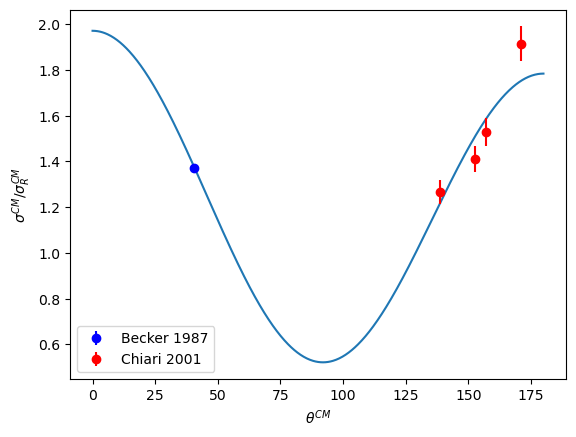

In [58]:
plt.plot(theta_grid, yfit)
#plt.scatter(angles_cm[0],ratio_diffCrossSection_R[0], label="Becker 1987")
#plt.scatter(angles_cm[1:],ratio_diffCrossSection_R[1:], label="Chiari 2001")
plt.errorbar(angles_cm[0], ratio_diffCrossSection_R[0], yerr=sigma_r[0], fmt="o", ecolor='blue',c='blue',label="Becker 1987")
plt.errorbar(angles_cm[1:], ratio_diffCrossSection_R[1:], yerr=sigma_r[1:], fmt="o", ecolor='red',c='red',label="Chiari 2001")
plt.legend()
plt.xlabel(r'$\theta^{CM}$')
plt.ylabel(r'$\sigma^{CM}/\sigma^{CM}_{R}$')
plt.show()

In [64]:
# differential cross section in CM (barns)
model_diff_cross_cm = yfit*rutherford_diff_cross_section_CM(zp, zB, en_cm, theta_grid)*cm2_to_barns

theta_grid_lab = np.linspace(0, 180, 721)
theta_grid_cm = theta_LtoC(theta_grid_lab, gamma)

is_inf_diff_cross = model_diff_cross_cm != np.inf

model_diff_cross_cm = model_diff_cross_cm[is_inf_diff_cross]
theta_grid_cm = theta_grid_cm[is_inf_diff_cross]
theta_grid_lab = theta_grid_lab[is_inf_diff_cross]

/var/folders/sb/gtrmzjv52898jwr5g3trrhpc0000gp/T/ipykernel_1936/2681338505.py:67: RuntimeWarning: divide by zero encountered in divide
  return (numerator/denominator)**2


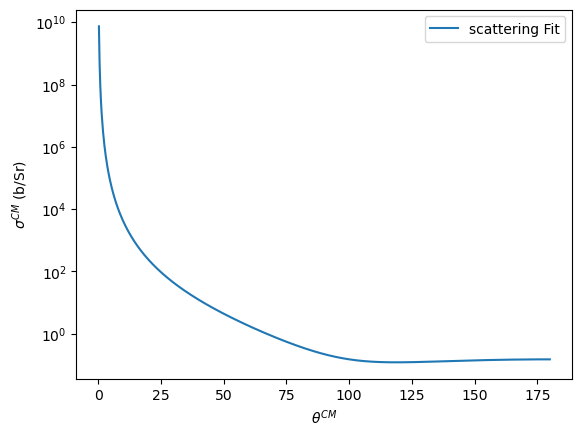

In [81]:
plt.plot(theta_grid_cm,model_diff_cross_cm,label="scattering Fit")
plt.yscale('log')
plt.xlabel(r'$\theta^{CM}$')
plt.ylabel(r'$\sigma^{CM}$ (b/Sr)')
plt.legend()
plt.show()

In [67]:
# Convert to lab frame
model_diff_cross_lab = model_diff_cross_cm * solidAngleRatio_cm2L(theta_grid_cm,theta_grid_lab,gamma)

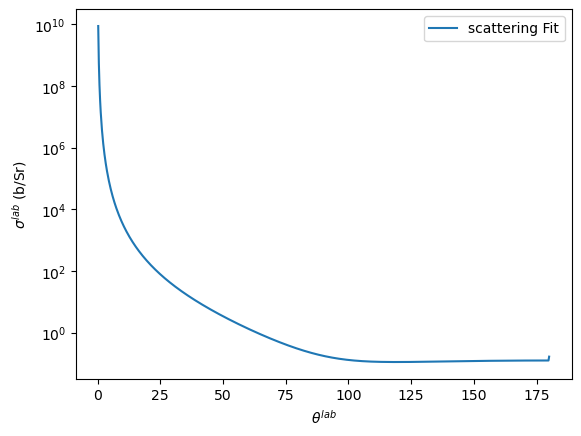

In [80]:
plt.plot(theta_grid_lab,model_diff_cross_lab,label="scattering Fit")
plt.yscale('log')
plt.xlabel(r'$\theta^{lab}$')
plt.ylabel(r'$\sigma^{lab}$ (b/Sr)')
plt.legend()
plt.show()

In [ ]:
a_Spraker = np.array([218.42, -3.17, 6.31])
gamma_reaction = gamma_calc(mp, mB11, mAlpha, mBe8, enp_lab, QBe8s)
X_lab = eval_legendre_linear(theta_grid_cm, a_Spraker)*10**(-3)*solidAngleRatio_cm2L(theta_grid_cm,theta_grid_lab,gamma_reaction)

# Get rid of angle at 180 degrees.
theta_grid_lab = theta_grid_lab[:719]
X_lab = X_lab[:719]
model_diff_cross_lab = model_diff_cross_lab[:719]

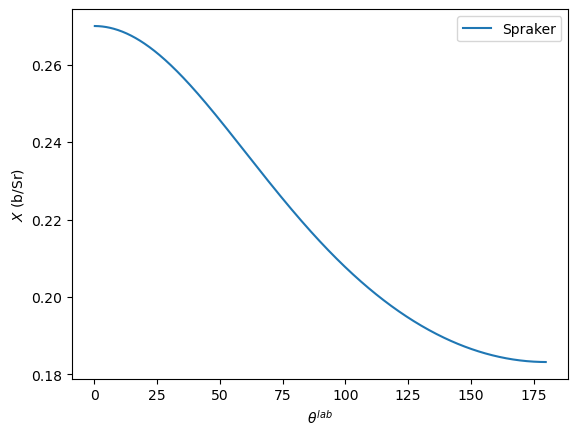

In [109]:
plt.plot(theta_grid_lab,X_lab,label="Spraker")
#plt.yscale('log')
plt.xlabel(r'$\theta^{lab}$')
plt.ylabel(r'$X$ (b/Sr)')
plt.legend()
plt.show()

In [108]:
theta_grid_lab

array([  0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,
         2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,
         4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,
         6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,
         8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,
        10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,
        12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,
        14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,
        16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,  18.  ,
        18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,  20.  ,
        20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,  22.  ,
        22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,  24.  ,
        24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,  26.  ,
        26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75,  28.  ,
      